In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [35]:
data=1000
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.003
c_reg2=0.0001

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0054548547764557>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.21411028113164>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.045556609126942704>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.03222779426168265>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([2.0105819 , 3.37257123, 1.43791017, 1.30948645, 1.13587387,
       2.28274875, 0.95550256, 4.43178985, 0.59219412, 2.47336568])>


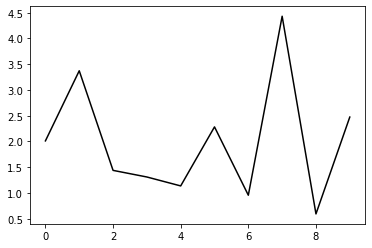

In [24]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [16]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tanh(100*(a-0.1))-tanh(100*(a+0.1))+2)

In [17]:
x=[i*0.1 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 2.60581612e-01 -5.58472955e+00  5.38266808e+01 -3.08275478e+02
  1.16790041e+03 -3.08347723e+03  5.82285230e+03 -7.94502014e+03
  7.81868298e+03 -5.47798636e+03  2.66286328e+03 -8.59692413e+02
  1.71291955e+02 -1.84108983e+01  9.55260239e-01 -6.54557458e-05]


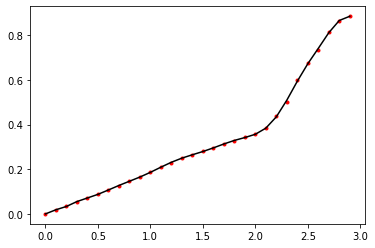

In [18]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.1) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [32]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<data:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<data:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [ ]:
Positive=NN_func_p(f)
Negative=NN_func_n(f)

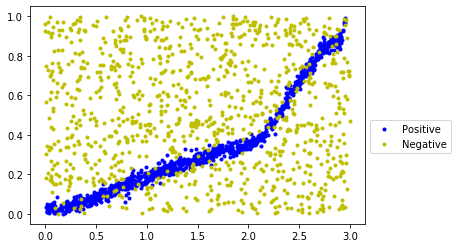

In [44]:
x_data1=[v[0] for v in Positive]
y_data1=[v[1] for v in Positive]
x_data2=[v[0] for v in Negative]
y_data2=[v[1] for v in Negative]
plt.plot(x_data1, y_data1, 'b.', label='Positive')
plt.plot(x_data2, y_data2, 'y.', label='Negative')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [37]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [38]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=1.5*(D-1)*alpha*HH+1.5*(-D-1)*beta*MM
    for j in range (layer):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    for i in range (data):
        H=list_hr[i][0]
        M=list_hr[i][1]
        if np.abs(LP2(hh, m, la, alpha, beta, H, M)[1])<0.1: PP.append([H, M])
        else: NN.append([H, M])
    return PP, NN

In [39]:
[Positive0, Positive1]=NN_func_01(h, m2, lam, alpha, beta, Positive)
[Negative0, Negative1]=NN_func_01(h, m2, lam, alpha, beta, Negative)

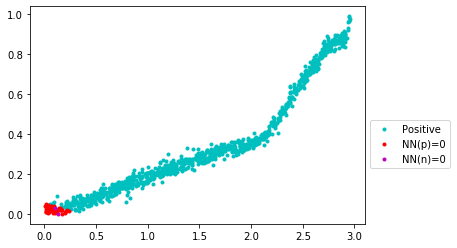

46 954
2 998


In [43]:
x_data1=[v[0] for v in Positive0]
y_data1=[v[1] for v in Positive0]
x_data2=[v[0] for v in Positive1]
y_data2=[v[1] for v in Positive1]
x_data3=[v[0] for v in Negative0]
y_data3=[v[1] for v in Negative0]
x_data4=[v[0] for v in Negative1]
y_data4=[v[1] for v in Negative1]
plt.plot(x_data2, y_data2, 'c.', label='Positive')
plt.plot(x_data1, y_data1, 'r.', label='NN(p)=0')
plt.plot(x_data3, y_data3, 'm.', label='NN(n)=0')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()
print(len(Positive0), len(Positive1))
print(len(Negative0), len(Negative1))

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [47]:
def Error_func(hh, m, la, alpha, beta):
    sum_p=0
    for i in range (data):
        H=Positive[i][0]
        M=Positive[i][1]
        H0, M0=LP2(hh, m, la, alpha, beta, H, M)
        sum_p=sum_p+t_func(M0)
    sum_n=0
    for i in range (data):
        H=Negative[i][0]
        M=Negative[i][0]
        H0, M0 = LP2(hh, m, la, alpha, beta, H, M)
        sum_n=sum_n+1-t_func(M0)

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return E_reg1+E_reg2+sum_p+sum_n

In [48]:
print("Error(h) =", Error_func(h, m2, lam, alpha, beta))

Error(h) = tf.Tensor(969.5883820175416, shape=(), dtype=float64)


In [49]:
def run():
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta)
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
    return loss

# Optimize

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.001)
for i in range (1, 2001):
    loss=run()
    print(i, loss.numpy(), m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
    if i%200==0: plt.plot(h_real, 'r-'), plt.plot(h.numpy(), 'k-'), plt.show()

1 969.5883820175416 3.004454855148469 1.2131400504732348 0.044556609088021136 -0.031227794238326834
[2.0115819  3.37157123 1.43691017 1.30848645 1.13487387 2.28174875
 0.95450257 4.43078985 0.59119413 2.47236568]


In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.001)
for i in range (1, 2001):
    loss=run()
    print(i, loss.numpy(), m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
    if i%200==0: plt.plot(h_real, 'r-'), plt.plot(h.numpy(), 'k-'), plt.show()

1 100.0004870116303 [2.6444779  2.66351198 2.67903162 2.69838853 2.72768958 2.77923713
 2.88416655 3.14052611 3.95248665 8.07017254]
2 100.00048061415079 [2.65366202 2.65517448 2.67163672 2.69286457 2.72441706 2.7782392
 2.88483024 3.14044084 3.95262771 8.08010699]
3 102.0003432515181 [2.66005126 2.64877632 2.66524748 2.68647602 2.71802921 2.77185232
 2.87844498 3.13405766 3.94625108 8.08679479]
4 100.00047486135918 [2.66528288 2.64354333 2.66001464 2.68124384 2.71279768 2.76662169
 2.87321598 3.12883131 3.94103092 8.09459413]
5 100.00047345337836 [2.66970666 2.63912645 2.65558838 2.67681822 2.70837268 2.76219754
 2.86879348 3.12441189 3.93661784 8.10300963]
6 101.00047202353288 [2.67351625 2.63533266 2.65177524 2.67300572 2.70456078 2.75838646
 2.86498408 3.12060596 3.93281874 8.11181464]
7 100.00047083458298 [2.67684247 2.63203144 2.64844432 2.66967541 2.70123107 2.75505754
 2.86165686 3.11728249 3.9295028  8.12088441]
8 100.00046956417846 [2.67977394 2.62913446 2.64550704 2.66673874

62 100.00046295517919 [2.60244336 2.70645627 2.72284466 2.74410394 2.77571323 2.82963917
 2.93642716 3.19243695 4.00556409 8.21276929]
63 100.00046301081652 [2.60237903 2.70652032 2.72290883 2.7441681  2.77577742 2.82970343
 2.93649158 3.19250173 4.00562972 8.21285635]
64 100.00046306079759 [2.60232067 2.70657841 2.72296705 2.74422631 2.77583565 2.82976173
 2.93655003 3.19256049 4.00568926 8.21293723]
65 100.00046310561811 [2.60226773 2.70663109 2.72301986 2.74427911 2.77588847 2.82981461
 2.93660304 3.1926138  4.00574327 8.21301251]
66 100.00046314573225 [2.60221971 2.70667885 2.72306776 2.74432701 2.77593639 2.82986257
 2.93665113 3.19266215 4.00579226 8.21308271]
67 100.00046318155582 [2.60217616 2.70672215 2.7231112  2.74437044 2.77597984 2.82990608
 2.93669474 3.192706   4.0058367  8.21314832]
68 100.00046321346917 [2.60213667 2.7067614  2.72315059 2.74440983 2.77601924 2.82994552
 2.93673429 3.19274577 4.00587699 8.21320976]
69 100.00046324181997 [2.60210087 2.70679698 2.72318631

123 100.00046317261261 [2.6017582  2.70712851 2.72352862 2.74478784 2.77639742 2.83032416
 2.93711399 3.19312786 4.006265   8.21489148]
124 100.0004631641943 [2.60175807 2.70712842 2.72352876 2.74478798 2.77639756 2.8303243
 2.93711413 3.19312801 4.00626518 8.21491833]
125 100.00046315572537 [2.60175796 2.70712831 2.72352888 2.7447881  2.77639768 2.83032443
 2.93711426 3.19312814 4.00626534 8.21494527]
126 100.00046314720731 [2.60175786 2.70712819 2.723529   2.74478821 2.7763978  2.83032454
 2.93711438 3.19312827 4.00626548 8.21497231]
127 100.00046313864145 [2.60175777 2.70712805 2.7235291  2.74478831 2.7763979  2.83032465
 2.93711448 3.19312838 4.00626562 8.21499945]
128 100.00046313002899 [2.60175769 2.7071279  2.72352919 2.7447884  2.77639799 2.83032474
 2.93711458 3.19312848 4.00626574 8.21502669]
129 100.00046312137106 [2.60175763 2.70712774 2.72352926 2.74478848 2.77639807 2.83032482
 2.93711466 3.19312858 4.00626586 8.21505404]
130 100.00046311266865 [2.60175757 2.70712757 2.72

184 100.00046258850854 [2.60175808 2.70711343 2.72352952 2.74478877 2.7763984  2.8303252
 2.93711519 3.19312956 4.00626815 8.2167176 ]
185 100.00046257789457 [2.60175811 2.70711313 2.72352951 2.74478876 2.77639839 2.83032519
 2.93711519 3.19312957 4.00626818 8.21675067]
186 100.00046256724949 [2.60175813 2.70711282 2.7235295  2.74478875 2.77639838 2.83032518
 2.93711518 3.19312957 4.00626821 8.21678384]
187 100.00046255657334 [2.60175816 2.70711252 2.72352949 2.74478874 2.77639837 2.83032518
 2.93711517 3.19312957 4.00626824 8.2168171 ]
188 100.0004625458662 [2.60175818 2.70711222 2.72352948 2.74478873 2.77639836 2.83032517
 2.93711517 3.19312958 4.00626826 8.21685046]
189 100.00046253512815 [2.60175821 2.70711191 2.72352946 2.74478872 2.77639835 2.83032516
 2.93711516 3.19312958 4.00626829 8.21688392]
190 100.00046252435925 [2.60175823 2.70711161 2.72352945 2.74478871 2.77639834 2.83032515
 2.93711516 3.19312958 4.00626832 8.21691747]
191 100.00046251355955 [2.60175826 2.7071113  2.72

245 100.0004618862465 [2.60175977 2.70709347 2.72352876 2.74478807 2.77639775 2.83032461
 2.9371148  3.19312977 4.00627009 8.2189063 ]
246 100.00046187383857 [2.6017598  2.70709312 2.72352875 2.74478805 2.77639774 2.8303246
 2.93711479 3.19312977 4.00627012 8.21894499]
247 100.00046186140273 [2.60175983 2.70709277 2.72352874 2.74478804 2.77639773 2.83032459
 2.93711478 3.19312977 4.00627016 8.21898376]
248 100.00046184893903 [2.60175986 2.70709241 2.72352872 2.74478803 2.77639771 2.83032458
 2.93711478 3.19312978 4.00627019 8.21902262]
249 100.00046183644749 [2.60175989 2.70709206 2.72352871 2.74478802 2.7763977  2.83032457
 2.93711477 3.19312978 4.00627023 8.21906157]
250 100.00046182392816 [2.60175992 2.7070917  2.72352869 2.744788   2.77639769 2.83032456
 2.93711476 3.19312978 4.00627026 8.21910061]
251 100.00046181138109 [2.60175996 2.70709135 2.72352868 2.74478799 2.77639768 2.83032455
 2.93711475 3.19312979 4.0062703  8.21913974]
252 100.0004617988063 [2.60175999 2.70709099 2.723

306 100.00046107963566 [2.60176173 2.7070705  2.72352788 2.74478725 2.77639699 2.83032393
 2.93711434 3.19312999 4.00627238 8.22142271]
307 100.0004610655917 [2.60176176 2.7070701  2.72352786 2.74478723 2.77639698 2.83032392
 2.93711433 3.19313    4.00627242 8.22146655]
308 100.0004610515219 [2.6017618  2.7070697  2.72352785 2.74478722 2.77639697 2.83032391
 2.93711432 3.19313    4.00627246 8.22151047]
309 100.0004610374263 [2.60176183 2.7070693  2.72352783 2.7447872  2.77639695 2.83032389
 2.93711431 3.19313001 4.0062725  8.22155448]
310 100.00046102330495 [2.60176186 2.7070689  2.72352782 2.74478719 2.77639694 2.83032388
 2.93711431 3.19313001 4.00627254 8.22159856]
311 100.00046100915786 [2.6017619  2.7070685  2.7235278  2.74478718 2.77639693 2.83032387
 2.9371143  3.19313001 4.00627258 8.22164273]
312 100.00046099498503 [2.60176193 2.70706809 2.72352779 2.74478716 2.77639691 2.83032386
 2.93711429 3.19313002 4.00627262 8.22168698]
313 100.00046098078654 [2.60176197 2.70706769 2.723

367 100.00046017663364 [2.60176392 2.70704472 2.72352688 2.74478633 2.77639614 2.83032316
 2.93711382 3.19313025 4.00627501 8.22424376]
368 100.00046016106091 [2.60176396 2.70704428 2.72352686 2.74478631 2.77639613 2.83032315
 2.93711381 3.19313025 4.00627506 8.22429245]
369 100.00046014546383 [2.601764   2.70704383 2.72352685 2.7447863  2.77639612 2.83032314
 2.93711381 3.19313026 4.00627511 8.22434121]
370 100.00046012984242 [2.60176403 2.70704338 2.72352683 2.74478628 2.7763961  2.83032312
 2.9371138  3.19313026 4.00627515 8.22439006]
371 100.0004601141967 [2.60176407 2.70704293 2.72352681 2.74478626 2.77639609 2.83032311
 2.93711379 3.19313027 4.0062752  8.22443898]
372 100.00046009852669 [2.60176411 2.70704249 2.72352679 2.74478625 2.77639607 2.8303231
 2.93711378 3.19313027 4.00627524 8.22448798]
373 100.0004600828324 [2.60176415 2.70704204 2.72352678 2.74478623 2.77639606 2.83032308
 2.93711377 3.19313028 4.00627529 8.22453706]
374 100.00046006711386 [2.60176419 2.70704159 2.723

428 100.0004591828273 [2.60176634 2.70701625 2.72352577 2.74478531 2.77639521 2.83032232
 2.93711325 3.19313053 4.00627801 8.22735374]
429 100.00045916580358 [2.60176638 2.70701577 2.72352575 2.74478529 2.77639519 2.8303223
 2.93711324 3.19313054 4.00627806 8.22740706]
430 100.0004591487566 [2.60176642 2.70701528 2.72352573 2.74478528 2.77639518 2.83032229
 2.93711323 3.19313054 4.00627811 8.22746046]
431 100.00045913168638 [2.60176647 2.70701479 2.72352571 2.74478526 2.77639516 2.83032227
 2.93711323 3.19313055 4.00627817 8.22751393]
432 100.00045911459296 [2.60176651 2.7070143  2.72352569 2.74478524 2.77639514 2.83032226
 2.93711322 3.19313055 4.00627822 8.22756747]
433 100.00045909747631 [2.60176655 2.7070138  2.72352567 2.74478522 2.77639513 2.83032224
 2.93711321 3.19313056 4.00627827 8.2276211 ]
434 100.00045908033647 [2.60176659 2.70701331 2.72352565 2.74478521 2.77639511 2.83032223
 2.9371132  3.19313056 4.00627833 8.22767479]
435 100.00045906317345 [2.60176663 2.70701282 2.723

489 100.00045810235476 [2.60176898 2.70698519 2.72352455 2.7447842  2.77639419 2.83032139
 2.93711263 3.19313084 4.00628138 8.23074148]
490 100.00045808393892 [2.60176903 2.70698466 2.72352453 2.74478418 2.77639417 2.83032138
 2.93711262 3.19313085 4.00628144 8.23079929]
491 100.00045806550068 [2.60176907 2.70698413 2.7235245  2.74478417 2.77639415 2.83032136
 2.93711261 3.19313085 4.0062815  8.23085716]
492 100.00045804704003 [2.60176912 2.7069836  2.72352448 2.74478415 2.77639413 2.83032135
 2.9371126  3.19313086 4.00628156 8.23091511]
493 100.000458028557 [2.60176916 2.70698307 2.72352446 2.74478413 2.77639412 2.83032133
 2.93711259 3.19313086 4.00628162 8.23097313]
494 100.00045801005162 [2.60176921 2.70698254 2.72352444 2.74478411 2.7763941  2.83032131
 2.93711258 3.19313087 4.00628168 8.23103122]
495 100.00045799152386 [2.60176925 2.706982   2.72352442 2.74478409 2.77639408 2.8303213
 2.93711257 3.19313087 4.00628174 8.23108938]
496 100.00045797297375 [2.6017693  2.70698147 2.723

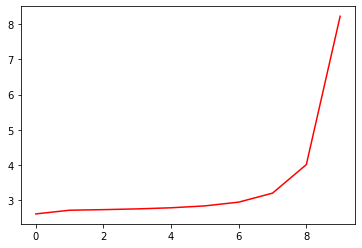

In [20]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00045789855008 [2.61171959 2.69703541 2.71549541 2.73798708 2.77106792 2.82658399
 2.9352531  3.19371094 4.00875905 8.24122279]
2 100.00044391802976 [2.62157302 2.68722276 2.70679866 2.73035255 2.76461629 2.82166617
 2.93239952 3.19390374 4.01191204 8.2511499 ]
3 100.00043239693038 [2.63120694 2.67770906 2.69778183 2.72225052 2.7575327  2.81597175
 2.92872604 3.19331687 4.01543849 8.26108683]
4 100.00042332940549 [2.64045865 2.66872443 2.688586   2.71382868 2.7500205  2.80971099
 2.92435835 3.19188112 4.01914547 8.27102724]
5 100.00041658759957 [2.64911715 2.66056707 2.6793552  2.70516759 2.74218575 2.80301037
 2.91939674 3.1896696  4.02286662 8.2809675 ]
6 101.00159794958614 [2.64389641 2.66578353 2.68457588 2.71038831 2.74740645 2.80823102
 2.92461735 3.19489018 4.0280878  8.28705306]
7 100.00041088071471 [2.63933716 2.67033884 2.68913505 2.71494747 2.75196557 2.8127901
 2.92917639 3.19944921 4.03264758 8.29259227]
8 100.00041047264283 [2.63531797 2.67435417 2.69315415 2.718966

62 100.00039609817286 [2.5981767  2.71034754 2.73034914 2.75613844 2.79315401 2.85397451
 2.97035834 3.24064087 4.07404928 8.46387141]
63 100.00039527263634 [2.59816016 2.71032855 2.73036734 2.75615627 2.79317177 2.85399217
 2.97037594 3.24065875 4.07407476 8.46700881]
64 100.00039444249248 [2.59814548 2.71030736 2.73038368 2.75617224 2.79318767 2.85400797
 2.97039169 3.24067477 4.07409857 8.4701603 ]
65 100.00039360806446 [2.59813251 2.71028415 2.73039831 2.75618652 2.79320189 2.85402209
 2.97040574 3.24068911 4.07412086 8.47332568]
66 100.00039276965576 [2.59812109 2.71025908 2.73041139 2.75619926 2.79321456 2.85403466
 2.97041826 3.24070191 4.0741418  8.47650477]
67 100.0003919275517 [2.59811108 2.71023229 2.73042307 2.75621061 2.79322585 2.85404584
 2.97042938 3.24071331 4.07416152 8.47969736]
68 100.00039108202087 [2.59810234 2.71020392 2.73043346 2.7562207  2.79323586 2.85405575
 2.97043923 3.24072345 4.07418016 8.48290323]
69 100.00039023331638 [2.59809477 2.71017408 2.73044269 

123 100.00034366246219 [2.59821113 2.70768943 2.73039562 2.75619983 2.79321033 2.8540236
 2.97040328 3.24070808 4.07497134 8.67309093]
124 100.00034283137033 [2.59821575 2.70763564 2.73039166 2.75619699 2.7932074  2.85402054
 2.97040013 3.24070541 4.07499043 8.67669085]
125 100.00034200249566 [2.59822039 2.70758166 2.73038764 2.75619413 2.79320446 2.85401745
 2.97039697 3.24070273 4.07500978 8.68029245]
126 100.00034117587754 [2.59822506 2.7075275  2.73038357 2.75619126 2.79320149 2.85401435
 2.97039379 3.24070003 4.07502941 8.68389556]
127 100.0003403515544 [2.59822974 2.70747316 2.73037945 2.75618836 2.79319851 2.85401123
 2.97039059 3.24069732 4.07504931 8.68750004]
128 100.0003395295638 [2.59823445 2.70741863 2.73037527 2.75618546 2.79319551 2.85400809
 2.97038738 3.2406946  4.07506949 8.69110575]
129 100.00033870994241 [2.59823917 2.70736393 2.73037105 2.75618253 2.7931925  2.85400494
 2.97038415 3.24069186 4.07508995 8.69471253]
130 100.00033789272601 [2.59824392 2.70730905 2.730

184 100.00029803923536 [2.59852441 2.70411923 2.73005265 2.75600041 2.7930072  2.85381123
 2.97018581 3.24052946 4.07668006 8.89111043]
185 100.00029738894698 [2.59853    2.70405654 2.73004518 2.75599673 2.79300351 2.85380738
 2.97018186 3.24052636 4.076718   8.89458941]
186 100.00029674202169 [2.5985356  2.70399373 2.73003764 2.75599302 2.7929998  2.85380351
 2.97017791 3.24052325 4.07675628 8.89806342]
187 100.00029609846247 [2.59854122 2.70393082 2.73003004 2.75598931 2.79299609 2.85379963
 2.97017394 3.24052015 4.0767949  8.90153239]
188 100.00029545827199 [2.59854685 2.70386779 2.73002237 2.75598557 2.79299236 2.85379574
 2.97016996 3.24051704 4.07683386 8.90499625]
189 100.00029482145251 [2.59855249 2.70380465 2.73001464 2.75598183 2.79298863 2.85379183
 2.97016597 3.24051392 4.07687317 8.90845492]
190 100.000294188006 [2.59855814 2.7037414  2.73000684 2.75597807 2.79298488 2.85378792
 2.97016197 3.2405108  4.07691281 8.91190834]
191 100.00029355793399 [2.59856381 2.70367804 2.72

245 100.0002644738239 [2.59888717 2.70011846 2.72947087 2.75574833 2.79276236 2.85355596
 2.96992518 3.2403383  4.07963368 9.09200593]
246 100.0002640236269 [2.59889345 2.70005038 2.72945907 2.7557437  2.79275803 2.85355145
 2.96992058 3.2403352  4.07969316 9.09507538]
247 100.00026357648072 [2.59889974 2.69998223 2.7294472  2.75573906 2.79275368 2.85354693
 2.96991598 3.24033211 4.07975299 9.09813675]
248 100.00026313237444 [2.59890604 2.69991402 2.72943525 2.7557344  2.79274932 2.85354239
 2.96991136 3.24032902 4.07981319 9.10119002]
249 100.000262691297 [2.59891236 2.69984575 2.72942323 2.75572972 2.79274495 2.85353785
 2.96990674 3.24032594 4.07987375 9.10423516]
250 100.00026225323721 [2.59891868 2.69977741 2.72941113 2.75572503 2.79274057 2.8535333
 2.9699021  3.24032286 4.07993467 9.10727213]
251 100.00026181818382 [2.59892501 2.69970901 2.72939895 2.75572031 2.79273618 2.85352874
 2.96989745 3.24031978 4.07999595 9.1103009 ]
252 100.00026138612543 [2.59893135 2.69964055 2.72938

306 100.0002421560663 [2.59928696 2.69586955 2.72860673 2.75543168 2.79247902 2.85326252
 2.96962722 3.24016061 4.08391945 9.2636208 ]
307 100.00024186910012 [2.59929376 2.69579865 2.72859004 2.75542585 2.79247406 2.8532574
 2.96962205 3.24015797 4.08400073 9.26615913]
308 100.00024158439312 [2.59930058 2.69572772 2.72857327 2.75542    2.79246908 2.85325228
 2.96961687 3.24015533 4.08408235 9.26868837]
309 100.00024130193151 [2.5993074  2.69565676 2.72855641 2.75541413 2.7924641  2.85324715
 2.96961168 3.24015271 4.08416433 9.27120853]
310 100.00024102170147 [2.59931424 2.69558578 2.72853947 2.75540823 2.7924591  2.85324201
 2.96960649 3.2401501  4.08424665 9.2737196 ]
311 100.00024074368922 [2.59932107 2.69551476 2.72852244 2.75540231 2.7924541  2.85323686
 2.96960128 3.2401475  4.08432932 9.27622159]
312 100.00024046788094 [2.59932792 2.69544373 2.72850534 2.75539637 2.79244908 2.8532317
 2.96959607 3.24014491 4.08441234 9.27871447]
313 100.00024019426287 [2.59933477 2.69537266 2.728

367 100.00022829863873 [2.59971475 2.69151034 2.72743409 2.75503133 2.79215683 2.85293349
 2.96929638 3.24002463 4.08949801 9.40187207]
368 100.00022812502124 [2.59972195 2.69143859 2.72741222 2.75502395 2.79215121 2.85292781
 2.96929071 3.24002292 4.08959961 9.40386078]
369 100.00022795286999 [2.59972916 2.69136684 2.72739027 2.75501653 2.79214558 2.85292212
 2.96928503 3.24002122 4.08970152 9.40584073]
370 100.00022778217333 [2.59973638 2.69129509 2.72736823 2.75500909 2.79213993 2.85291642
 2.96927934 3.24001954 4.08980375 9.40781193]
371 100.00022761291964 [2.5997436  2.69122334 2.72734611 2.75500161 2.79213428 2.85291072
 2.96927365 3.24001788 4.08990629 9.40977439]
372 100.00022744509735 [2.59975083 2.69115159 2.7273239  2.75499411 2.79212861 2.852905
 2.96926794 3.24001624 4.09000914 9.41172813]
373 100.00022727869494 [2.59975806 2.69107984 2.72730161 2.75498658 2.79212294 2.85289927
 2.96926223 3.24001461 4.09011231 9.41367315]
374 100.00022711370097 [2.59976529 2.6910081  2.72

428 100.00022000075096 [2.6001634  2.68714693 2.72594424 2.754524   2.79179243 2.8525704
 2.96893713 3.23995944 4.09624261 9.50770384]
429 100.00021989727556 [2.60017089 2.68707585 2.72591719 2.75451465 2.79178607 2.85256417
 2.96893103 3.23995912 4.09636194 9.50918784]
430 100.00021979466037 [2.60017839 2.68700478 2.72589006 2.75450526 2.7917797  2.85255793
 2.96892492 3.23995883 4.09648154 9.51066416]
431 100.0002196928973 [2.60018589 2.68693374 2.72586285 2.75449585 2.79177332 2.85255168
 2.96891881 3.23995856 4.0966014  9.51213282]
432 100.00021959197832 [2.6001934  2.68686273 2.72583555 2.75448639 2.79176692 2.85254542
 2.96891269 3.23995832 4.09672152 9.51359386]
433 100.00021949189546 [2.60020091 2.68679173 2.72580817 2.7544769  2.79176051 2.85253915
 2.96890657 3.23995811 4.09684191 9.51504728]
434 100.00021939264082 [2.60020842 2.68672076 2.72578071 2.75446737 2.79175409 2.85253288
 2.96890044 3.23995792 4.09696256 9.51649312]
435 100.00021929420649 [2.60021594 2.68664981 2.72

489 100.0002150013064 [2.60062712 2.68286013 2.72414413 2.75388481 2.79137935 2.8521738
 2.96855436 3.23999288 4.10397609 9.58500184]
490 100.00021493751507 [2.60063482 2.68279085 2.72411213 2.7538731  2.79137212 2.85216702
 2.96854792 3.23999439 4.10411001 9.58605989]
491 100.00021487419107 [2.60064252 2.68272161 2.72408005 2.75386134 2.79136488 2.85216022
 2.96854147 3.23999594 4.10424415 9.5871117 ]
492 100.00021481132954 [2.60065023 2.68265241 2.7240479  2.75384955 2.79135762 2.85215342
 2.96853502 3.23999752 4.10437849 9.5881573 ]
493 100.00021474892563 [2.60065794 2.68258325 2.72401566 2.75383771 2.79135035 2.85214662
 2.96852857 3.23999914 4.10451305 9.58919671]
494 100.00021468697457 [2.60066565 2.68251412 2.72398335 2.75382582 2.79134306 2.8521398
 2.96852211 3.24000078 4.10464781 9.59022996]
495 100.00021462547163 [2.60067336 2.68244503 2.72395097 2.7538139  2.79133575 2.85213297
 2.96851564 3.24000247 4.10478279 9.59125707]
496 100.00021456441209 [2.60068108 2.68237598 2.723

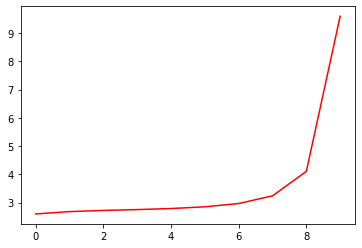

In [21]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00021432451568 [2.61063996 2.67226548 2.71415873 2.74516042 2.78447951 2.84675895
 2.9646892  3.24100316 4.11303518 9.60429744]
2 100.0002059972523 [2.6204231  2.66270659 2.70440748 2.73618759 2.77676288 2.84037892
 2.96016031 3.2415384  4.12127087 9.61352031]
3 100.00020009178444 [2.62984576 2.65406914 2.69462859 2.7270391  2.76858704 2.83341271
 2.95521499 3.2411342  4.12974477 9.62281435]
4 100.00019647565269 [2.63862521 2.64720813 2.68486928 2.71777933 2.76011653 2.82605735
 2.94992762 3.23979531 4.13834615 9.63211236]
5 100.00019468010744 [2.64643587 2.64286652 2.67522519 2.70844067 2.75143671 2.81842197
 2.94430588 3.23769669 4.14701182 9.64136936]
6 100.00019396972174 [2.65297363 2.64114161 2.66592213 2.6990513  2.74260279 2.81057639
 2.93835637 3.23503091 4.15569719 9.65054758]
7 101.04609206757732 [2.64790986 2.64620537 2.67098585 2.70411505 2.74766654 2.81564015
 2.94342013 3.24009467 4.16076123 9.65561374]
8 100.53697830974508 [2.64227068 2.65184835 2.67663008 2.709760

62 100.00022830485621 [2.59001242 2.70413741 2.7289353  2.76207504 2.80563652 2.87362072
 3.00141424 3.29811057 4.21882976 9.71384898]
63 100.00022834501986 [2.58998459 2.70416511 2.72896316 2.7621029  2.80566438 2.87364859
 3.00144212 3.29813847 4.21885784 9.71387731]
64 100.00022838146936 [2.58995934 2.70419021 2.72898844 2.76212817 2.80568966 2.87367388
 3.00146741 3.29816378 4.21888333 9.71390305]
65 100.00022841454165 [2.58993644 2.70421297 2.72901137 2.7621511  2.80571259 2.87369681
 3.00149036 3.29818673 4.21890647 9.71392643]
66 100.00022844454382 [2.58991567 2.7042336  2.72903217 2.76217189 2.80573339 2.87371761
 3.00151116 3.29820755 4.21892748 9.71394767]
67 100.00022847175563 [2.58989683 2.70425229 2.72905103 2.76219074 2.80575225 2.87373648
 3.00153004 3.29822644 4.21894654 9.71396696]
68 100.0002284964319 [2.58987975 2.70426921 2.72906813 2.76220784 2.80576935 2.87375359
 3.00154715 3.29824356 4.21896385 9.71398449]
69 100.0002285188046 [2.58986427 2.70428454 2.72908363 2

123 100.00022872729869 [2.58971658 2.70442161 2.72923192 2.76237108 2.80593272 2.87391712
 3.00171087 3.2984076  4.21913918 9.71417126]
124 100.00022872722558 [2.58971654 2.70442142 2.72923197 2.76237112 2.80593276 2.87391717
 3.00171092 3.29840766 4.21913946 9.71417177]
125 100.00022872714274 [2.5897165  2.70442123 2.72923201 2.76237115 2.80593279 2.87391721
 3.00171096 3.29840771 4.21913975 9.71417228]
126 100.00022872705107 [2.58971647 2.70442103 2.72923205 2.76237118 2.80593282 2.87391724
 3.00171099 3.29840775 4.21914002 9.71417278]
127 100.00022872695133 [2.58971645 2.70442082 2.72923209 2.7623712  2.80593285 2.87391727
 3.00171102 3.29840778 4.2191403  9.71417328]
128 100.00022872684423 [2.58971643 2.70442061 2.72923212 2.76237122 2.80593287 2.87391729
 3.00171105 3.29840782 4.21914056 9.71417378]
129 100.00022872673041 [2.58971641 2.7044204  2.72923215 2.76237123 2.80593289 2.87391731
 3.00171107 3.29840784 4.21914083 9.71417428]
130 100.00022872661044 [2.5897164  2.70442018 2.

184 100.00022871685819 [2.58971742 2.70440518 2.72923175 2.76237009 2.80593187 2.87391647
 3.00171043 3.29840754 4.21915505 9.71420258]
185 100.00022871665139 [2.58971744 2.70440487 2.72923174 2.76237006 2.80593184 2.87391645
 3.00171041 3.29840753 4.21915532 9.71420313]
186 100.00022871644396 [2.58971747 2.70440456 2.72923172 2.76237003 2.80593182 2.87391643
 3.00171039 3.29840752 4.2191556  9.71420369]
187 100.0002287162359 [2.5897175  2.70440425 2.72923171 2.76237    2.80593179 2.8739164
 3.00171037 3.2984075  4.21915588 9.71420425]
188 100.00022871602721 [2.58971752 2.70440393 2.72923169 2.76236997 2.80593176 2.87391638
 3.00171035 3.29840749 4.21915615 9.71420481]
189 100.00022871581788 [2.58971755 2.70440362 2.72923168 2.76236994 2.80593173 2.87391636
 3.00171033 3.29840748 4.21915643 9.71420537]
190 100.00022871560796 [2.58971758 2.70440331 2.72923166 2.76236991 2.8059317  2.87391633
 3.00171031 3.29840747 4.21915671 9.71420594]
191 100.00022871539741 [2.58971761 2.70440299 2.72

245 100.00022870315061 [2.58971921 2.70438465 2.72923076 2.76236811 2.80593006 2.8739149
 3.0017091  3.29840668 4.21917331 9.71423935]
246 100.00022870290812 [2.58971924 2.70438429 2.72923074 2.76236807 2.80593002 2.87391487
 3.00170908 3.29840666 4.21917363 9.71424   ]
247 100.00022870266507 [2.58971928 2.70438393 2.72923072 2.76236804 2.80592999 2.87391484
 3.00170905 3.29840664 4.21917395 9.71424065]
248 100.00022870242148 [2.58971931 2.70438356 2.7292307  2.762368   2.80592996 2.87391482
 3.00170903 3.29840663 4.21917428 9.7142413 ]
249 100.00022870217732 [2.58971934 2.70438319 2.72923069 2.76236797 2.80592993 2.87391479
 3.00170901 3.29840661 4.2191746  9.71424195]
250 100.00022870193263 [2.58971937 2.70438283 2.72923067 2.76236793 2.80592989 2.87391476
 3.00170898 3.2984066  4.21917493 9.71424261]
251 100.00022870168736 [2.5897194  2.70438246 2.72923065 2.7623679  2.80592986 2.87391473
 3.00170896 3.29840658 4.21917525 9.71424327]
252 100.00022870144156 [2.58971944 2.70438209 2.7

306 100.00022868736777 [2.58972128 2.70436102 2.7292296  2.76236582 2.80592797 2.87391309
 3.00170757 3.29840567 4.21919433 9.71428161]
307 100.00022868709263 [2.58972132 2.70436061 2.72922958 2.76236578 2.80592793 2.87391305
 3.00170755 3.29840566 4.21919469 9.71428234]
308 100.00022868681697 [2.58972135 2.7043602  2.72922956 2.76236574 2.80592789 2.87391302
 3.00170752 3.29840564 4.21919506 9.71428308]
309 100.0002286865408 [2.58972139 2.70435979 2.72922954 2.7623657  2.80592786 2.87391299
 3.00170749 3.29840562 4.21919543 9.71428382]
310 100.0002286862641 [2.58972143 2.70435937 2.72922952 2.76236566 2.80592782 2.87391296
 3.00170746 3.2984056  4.2191958  9.71428456]
311 100.00022868598688 [2.58972146 2.70435896 2.7292295  2.76236562 2.80592778 2.87391293
 3.00170744 3.29840559 4.21919617 9.7142853 ]
312 100.00022868570916 [2.5897215  2.70435854 2.72922948 2.76236558 2.80592775 2.8739129
 3.00170741 3.29840557 4.21919654 9.71428604]
313 100.00022868543091 [2.58972154 2.70435812 2.729

367 100.00022866965244 [2.58972361 2.7043345  2.7292283  2.76236326 2.80592562 2.87391105
 3.00170586 3.29840455 4.21921793 9.71432897]
368 100.0002286693465 [2.58972365 2.70433404 2.72922828 2.76236321 2.80592558 2.87391101
 3.00170583 3.29840453 4.21921834 9.71432979]
369 100.00022866904007 [2.58972369 2.70433358 2.72922825 2.76236317 2.80592554 2.87391098
 3.0017058  3.29840451 4.21921875 9.7143306 ]
370 100.00022866873314 [2.58972373 2.70433312 2.72922823 2.76236313 2.8059255  2.87391094
 3.00170577 3.29840449 4.21921916 9.71433142]
371 100.00022866842572 [2.58972377 2.70433266 2.72922821 2.76236308 2.80592546 2.87391091
 3.00170574 3.29840447 4.21921957 9.71433224]
372 100.00022866811781 [2.58972381 2.7043322  2.72922818 2.76236304 2.80592542 2.87391087
 3.00170571 3.29840445 4.21921998 9.71433307]
373 100.00022866780941 [2.58972385 2.70433174 2.72922816 2.76236299 2.80592537 2.87391084
 3.00170568 3.29840443 4.21922039 9.71433389]
374 100.00022866750051 [2.58972389 2.70433128 2.7

428 100.00022865009859 [2.58972617 2.70430522 2.72922685 2.76236043 2.80592303 2.8739088
 3.00170396 3.29840331 4.21924401 9.71438116]
429 100.00022864976312 [2.58972621 2.70430471 2.72922682 2.76236038 2.80592298 2.87390876
 3.00170393 3.29840329 4.21924445 9.71438206]
430 100.00022864942716 [2.58972626 2.70430421 2.7292268  2.76236033 2.80592294 2.87390872
 3.00170389 3.29840327 4.2192449  9.71438295]
431 100.00022864909073 [2.5897263  2.70430371 2.72922677 2.76236028 2.80592289 2.87390868
 3.00170386 3.29840325 4.21924535 9.71438385]
432 100.00022864875382 [2.58972635 2.7043032  2.72922675 2.76236023 2.80592285 2.87390864
 3.00170383 3.29840323 4.2192458  9.71438475]
433 100.00022864841644 [2.58972639 2.7043027  2.72922672 2.76236018 2.8059228  2.87390861
 3.0017038  3.29840321 4.21924625 9.71438565]
434 100.00022864807859 [2.58972644 2.70430219 2.7292267  2.76236013 2.80592276 2.87390857
 3.00170376 3.29840318 4.2192467  9.71438655]
435 100.00022864774026 [2.58972648 2.70430168 2.7

489 100.00022862877105 [2.58972897 2.70427327 2.72922525 2.76235734 2.8059202  2.87390634
 3.00170189 3.29840196 4.21927246 9.714438  ]
490 100.00022862840692 [2.58972902 2.70427272 2.72922523 2.76235728 2.80592015 2.8739063
 3.00170185 3.29840194 4.21927295 9.71443897]
491 100.00022862804232 [2.58972907 2.70427217 2.7292252  2.76235723 2.8059201  2.87390626
 3.00170182 3.29840192 4.21927344 9.71443994]
492 100.00022862767726 [2.58972911 2.70427163 2.72922517 2.76235718 2.80592005 2.87390622
 3.00170178 3.29840189 4.21927392 9.71444091]
493 100.00022862731174 [2.58972916 2.70427108 2.72922514 2.76235712 2.80592    2.87390617
 3.00170175 3.29840187 4.21927441 9.71444188]
494 100.00022862694576 [2.58972921 2.70427053 2.72922512 2.76235707 2.80591995 2.87390613
 3.00170171 3.29840185 4.2192749  9.71444286]
495 100.0002286265793 [2.58972926 2.70426998 2.72922509 2.76235702 2.8059199  2.87390609
 3.00170168 3.29840182 4.21927539 9.71444383]
496 100.00022862621239 [2.58972931 2.70426943 2.72

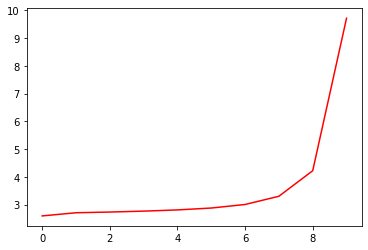

In [22]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00022862474009 [2.59968365 2.69432118 2.72080739 2.75380538 2.79834238 2.86780757
 2.99743813 3.29634542 4.2264441  9.72024207]
2 100.00021662566019 [2.60955429 2.6844946  2.71183989 2.74495341 2.79016277 2.86081441
 2.99212311 3.29381055 4.23419388 9.72643297]
3 100.00020706657595 [2.61923787 2.67493895 2.70260144 2.73596686 2.78168957 2.85333317
 2.98617345 3.29100823 4.24219409 9.73245101]
4 100.0001999585447 [2.62860117 2.66585942 2.69319482 2.7268902  2.77303595 2.84552744
 2.97979065 3.28802134 4.25030925 9.73786918]
5 100.0001952008022 [2.63747396 2.65752267 2.68371052 2.71773749 2.76425843 2.83748536
 2.97309683 3.28488526 4.25845749 9.74229057]
6 100.00019255788989 [2.64565312 2.65023491 2.67430972 2.70851635 2.75538888 2.82926288
 2.96617531 3.28161414 4.26657636 9.74542289]
7 100.00019164322903 [2.65292212 2.64428336 2.66534468 2.69924358 2.746446   2.82089974
 2.95908705 3.2782132  4.27461023 9.74717462]
8 100.99214610712227 [2.64796464 2.64924037 2.67030212 2.7042009

62 100.00021600284262 [2.60141625 2.69566781 2.7168582  2.75074065 2.79794119 2.8723954
 3.01058918 3.32973186 4.32625746 9.79788676]
63 100.00021602995332 [2.60139183 2.69568819 2.71688301 2.75076503 2.79796549 2.87241968
 3.01061356 3.3297565  4.32628488 9.7978829 ]
64 100.00021605428505 [2.60136972 2.69570622 2.71690552 2.75078709 2.7979875  2.87244166
 3.01063564 3.32977884 4.32631003 9.79787647]
65 100.00021607608788 [2.6013497  2.69572212 2.71692593 2.75080706 2.7980074  2.87246155
 3.01065562 3.32979909 4.32633311 9.79786768]
66 100.0002160955898 [2.60133159 2.69573607 2.71694445 2.75082513 2.79802541 2.87247953
 3.0106737  3.32981744 4.3263543  9.79785673]
67 100.00021611299857 [2.6013152  2.69574825 2.71696124 2.75084148 2.79804169 2.87249579
 3.01069006 3.32983406 4.3263738  9.7978438 ]
68 100.00021612850342 [2.60130038 2.69575883 2.71697647 2.75085625 2.7980564  2.87251047
 3.01070484 3.32984912 4.32639175 9.79782904]
69 100.00021614227668 [2.60128699 2.69576795 2.71699028 2

123 100.00021611605865 [2.60118149 2.69559577 2.71712199 2.75097275 2.79816855 2.87262107
 3.01082184 3.3299839  4.32671521 9.79601624]
124 100.00021611219691 [2.601182   2.69558937 2.71712201 2.75097218 2.7981679  2.87262038
 3.01082129 3.32998371 4.32671895 9.79597598]
125 100.0002161083131 [2.60118253 2.69558294 2.71712203 2.75097161 2.79816723 2.87261968
 3.01082072 3.32998352 4.3267227  9.79593557]
126 100.00021610440793 [2.60118306 2.69557647 2.71712205 2.75097103 2.79816656 2.87261898
 3.01082015 3.32998333 4.32672646 9.79589501]
127 100.00021610048205 [2.6011836  2.69556997 2.71712205 2.75097044 2.79816588 2.87261826
 3.01081958 3.32998313 4.32673023 9.7958543 ]
128 100.00021609653608 [2.60118414 2.69556345 2.71712206 2.75096985 2.7981652  2.87261754
 3.01081899 3.32998292 4.32673401 9.79581344]
129 100.00021609257054 [2.60118469 2.69555689 2.71712206 2.75096925 2.7981645  2.87261682
 3.0108184  3.32998271 4.32673781 9.79577244]
130 100.00021608858596 [2.60118525 2.6955503  2.7

184 100.00021585118915 [2.60122001 2.69515643 2.71711906 2.75093098 2.7981204  2.87257069
 3.01078057 3.32996819 4.32696657 9.79332233]
185 100.00021584643537 [2.60122071 2.69514849 2.71711897 2.75093021 2.79811952 2.87256977
 3.01077981 3.3299679  4.32697109 9.79327465]
186 100.00021584166976 [2.60122142 2.69514053 2.71711888 2.75092944 2.79811863 2.87256884
 3.01077905 3.32996761 4.32697563 9.79322686]
187 100.00021583689235 [2.60122214 2.69513254 2.71711879 2.75092867 2.79811775 2.87256791
 3.01077829 3.32996731 4.32698018 9.79317898]
188 100.00021583210322 [2.60122285 2.69512453 2.7171187  2.7509279  2.79811685 2.87256698
 3.01077752 3.32996702 4.32698475 9.793131  ]
189 100.0002158273024 [2.60122356 2.6951165  2.7171186  2.75092712 2.79811596 2.87256604
 3.01077675 3.32996672 4.32698932 9.79308293]
190 100.00021582248992 [2.60122428 2.69510845 2.71711851 2.75092635 2.79811506 2.87256511
 3.01077598 3.32996642 4.32699391 9.79303475]
191 100.00021581766586 [2.601225   2.69510038 2.7

245 100.00021554110658 [2.60126673 2.69463336 2.71711113 2.75088039 2.7980619  2.87250953
 3.0107303  3.32994894 4.32726455 9.79025295]
246 100.00021553570755 [2.60126756 2.69462416 2.71711095 2.7508795  2.79806087 2.87250844
 3.01072941 3.32994861 4.32726979 9.79020025]
247 100.0002155302991 [2.60126838 2.69461494 2.71711078 2.7508786  2.79805983 2.87250736
 3.01072852 3.32994827 4.32727504 9.79014749]
248 100.00021552488124 [2.60126921 2.6946057  2.7171106  2.75087771 2.79805879 2.87250627
 3.01072763 3.32994793 4.32728031 9.79009466]
249 100.00021551945404 [2.60127004 2.69459644 2.71711041 2.75087681 2.79805775 2.87250519
 3.01072673 3.32994759 4.32728558 9.79004176]
250 100.00021551401751 [2.60127087 2.69458717 2.71711023 2.75087591 2.79805671 2.87250409
 3.01072583 3.32994725 4.32729086 9.7899888 ]
251 100.00021550857169 [2.6012717  2.69457787 2.71711005 2.75087501 2.79805566 2.872503
 3.01072493 3.32994691 4.32729616 9.78993578]
252 100.0002155031166 [2.60127254 2.69456856 2.7171

306 100.00021519565252 [2.6013202  2.69403827 2.71709705 2.7508225  2.79799461 2.87243917
 3.01067243 3.32992721 4.32760344 9.78693384]
307 100.00021518973503 [2.60132113 2.69402796 2.71709676 2.7508215  2.79799344 2.87243794
 3.01067142 3.32992684 4.32760931 9.78687793]
308 100.00021518380994 [2.60132206 2.69401763 2.71709646 2.75082049 2.79799226 2.87243672
 3.01067041 3.32992646 4.32761519 9.78682198]
309 100.00021517787725 [2.60132299 2.69400729 2.71709617 2.75081948 2.79799108 2.87243548
 3.01066939 3.32992609 4.32762108 9.786766  ]
310 100.00021517193699 [2.60132392 2.69399693 2.71709587 2.75081847 2.79798991 2.87243425
 3.01066838 3.32992571 4.32762698 9.78670997]
311 100.00021516598919 [2.60132486 2.69398656 2.71709557 2.75081745 2.79798872 2.87243302
 3.01066736 3.32992533 4.32763289 9.78665391]
312 100.00021516003387 [2.60132579 2.69397616 2.71709526 2.75081644 2.79798754 2.87243178
 3.01066634 3.32992495 4.32763881 9.78659781]
313 100.00021515407109 [2.60132673 2.69396575 2.

367 100.00021482163946 [2.6013798  2.69337908 2.71707506 2.7507579  2.79791912 2.87236025
 3.01060746 3.32990335 4.32797884 9.7834647 ]
368 100.00021481530199 [2.60138083 2.69336778 2.71707462 2.75075678 2.79791782 2.87235889
 3.01060633 3.32990294 4.32798528 9.78340706]
369 100.00021480895833 [2.60138186 2.69335646 2.71707419 2.75075567 2.79791652 2.87235753
 3.01060521 3.32990253 4.32799172 9.78334941]
370 100.00021480260853 [2.60138288 2.69334512 2.71707374 2.75075455 2.79791521 2.87235616
 3.01060408 3.32990212 4.32799818 9.78329173]
371 100.00021479625259 [2.60138391 2.69333377 2.7170733  2.75075343 2.7979139  2.87235479
 3.01060296 3.32990171 4.32800464 9.78323404]
372 100.00021478989053 [2.60138495 2.6933224  2.71707285 2.75075232 2.79791259 2.87235342
 3.01060183 3.32990131 4.32801112 9.78317634]
373 100.00021478352238 [2.60138598 2.69331102 2.7170724  2.75075119 2.79791127 2.87235205
 3.0106007  3.3299009  4.3280176  9.78311862]
374 100.00021477714817 [2.60138701 2.69329963 2.

428 100.00021442448232 [2.60144511 2.69266199 2.71704339 2.75068694 2.79783586 2.8722732
 3.01053572 3.32987763 4.3283874  9.77992843]
429 100.00021441780474 [2.60144623 2.69264979 2.71704278 2.75068573 2.79783443 2.87227171
 3.01053449 3.3298772  4.32839436 9.7798703 ]
430 100.00021441112217 [2.60144735 2.69263756 2.71704217 2.75068451 2.797833   2.87227022
 3.01053326 3.32987676 4.32840133 9.77981218]
431 100.00021440443463 [2.60144847 2.69262533 2.71704155 2.75068329 2.79783157 2.87226872
 3.01053202 3.32987633 4.3284083  9.77975406]
432 100.00021439774214 [2.60144959 2.69261308 2.71704093 2.75068208 2.79783013 2.87226722
 3.01053079 3.32987589 4.32841529 9.77969594]
433 100.00021439104471 [2.60145071 2.69260081 2.71704031 2.75068085 2.7978287  2.87226572
 3.01052955 3.32987545 4.32842228 9.77963782]
434 100.00021438434234 [2.60145183 2.69258854 2.71703968 2.75067963 2.79782726 2.87226421
 3.01052831 3.32987501 4.32842928 9.77957971]
435 100.00021437763509 [2.60145296 2.69257624 2.7

489 100.00021400862992 [2.60151579 2.69189218 2.71700024 2.75060987 2.7977451  2.87217832
 3.01045745 3.32985032 4.3288265  9.77639485]
490 100.00021400167863 [2.60151699 2.69187914 2.71699942 2.75060856 2.79774355 2.8721767
 3.01045611 3.32984986 4.32883394 9.77633728]
491 100.00021399472334 [2.60151819 2.6918661  2.71699861 2.75060724 2.797742   2.87217508
 3.01045478 3.3298494  4.32884139 9.77627974]
492 100.00021398776407 [2.6015194  2.69185304 2.71699779 2.75060593 2.79774045 2.87217345
 3.01045344 3.32984894 4.32884884 9.77622221]
493 100.00021398080084 [2.6015206  2.69183997 2.71699696 2.75060461 2.79773889 2.87217183
 3.01045209 3.32984848 4.3288563  9.7761647 ]
494 100.00021397383365 [2.60152181 2.69182688 2.71699614 2.75060329 2.79773734 2.8721702
 3.01045075 3.32984802 4.32886378 9.7761072 ]
495 100.00021396686253 [2.60152302 2.69181378 2.71699531 2.75060197 2.79773578 2.87216857
 3.01044941 3.32984755 4.32887125 9.77604973]
496 100.00021395988749 [2.60152423 2.69180067 2.71

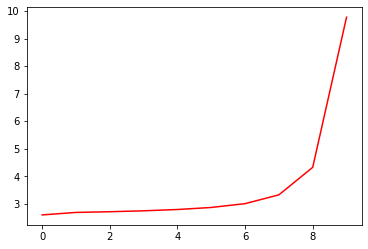

In [23]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.0002139319484 [2.6114698  2.68183229 2.70858116 2.74236829 2.79012826 2.86560482
 3.00575171 3.32846631 4.33431728 9.76879861]
2 100.00020489446783 [2.62128486 2.67210708 2.69962409 2.73371593 2.78194431 2.85829112
 3.00010575 3.32635262 4.34039813 9.76138395]
3 100.000198293327 [2.6308045  2.66287406 2.69040203 2.72484976 2.77347579 2.85058444
 2.99391277 3.32362866 4.34671018 9.75401994]
4 100.00019408338656 [2.63979664 2.65455708 2.68103757 2.71583761 2.76483001 2.84262387
 2.98734962 3.3204003  4.35302691 9.74700819]
5 100.0001920181482 [2.64796543 2.64767564 2.67171222 2.70671242 2.75605929 2.83448153
 2.98051439 3.31676064 4.35916991 9.74064895]
6 100.00019193527577 [2.64395847 2.64617799 2.67469164 2.70900166 2.75770059 2.83584112
 2.98226096 3.31966945 4.36605039 9.73592897]
7 100.00019189744698 [2.64047319 2.64555115 2.67658031 2.71033889 2.75839439 2.8362575
 2.98310688 3.32185576 4.37233261 9.73227763]
8 100.00019213153821 [2.63743213 2.6456059  2.67728584 2.71090049 2

62 100.0001909937863 [2.64326359 2.65004504 2.66207525 2.68236712 2.71745636 2.78284502
 2.92079411 3.25785272 4.3114505  9.73946107]
63 100.00019095785058 [2.64392169 2.65070545 2.66275933 2.6830265  2.71792403 2.78352094
 2.92194026 3.25911685 4.31492505 9.73988555]
64 100.00019092156413 [2.64458686 2.65137432 2.66346462 2.68365521 2.71842905 2.78429645
 2.92294581 3.26003725 4.31847747 9.74024418]
65 100.00019088509485 [2.64525895 2.65205261 2.66417776 2.68425693 2.71901153 2.78514092
 2.92379417 3.26071151 4.32202037 9.74052356]
66 100.00019084861707 [2.64593774 2.65274104 2.66488362 2.68485086 2.71969108 2.78601197
 2.92449107 3.26124113 4.32546673 9.74071908]
67 100.00019082650813 [2.64627068 2.65360222 2.66589321 2.6858048  2.72079227 2.78718213
 2.92535094 3.26197167 4.32886595 9.74087043]
68 100.00019094505613 [2.6430933  2.65616642 2.67000891 2.69006288 2.72511492 2.79135143
 2.92898813 3.26524057 4.33336354 9.74133497]
69 100.00019100608681 [2.64033594 2.65823991 2.67356251 

123 100.00019259931945 [2.62806356 2.64229507 2.66729869 2.70190728 2.7491381  2.82212944
 2.96267007 3.30103741 4.36893761 9.74176793]
124 100.00019242807436 [2.6283784  2.63965901 2.66272184 2.69709081 2.74565577 2.82065271
 2.96273806 3.30312675 4.37279731 9.74182332]
125 100.00019228592438 [2.62879187 2.63757982 2.65833896 2.69175175 2.7411729  2.81833948
 2.96248324 3.30486481 4.3760159  9.74193392]
126 100.0001921724287 [2.62926643 2.63608267 2.65439314 2.68618029 2.73584755 2.81510033
 2.96178789 3.30616594 4.37859181 9.74209971]
127 100.00019208376067 [2.62977387 2.63514166 2.6510658  2.6806919  2.72990816 2.81090716
 2.96048841 3.30694668 4.38053373 9.74230906]
128 100.00019201528909 [2.6302946  2.63469506 2.64846101 2.67559867 2.7236388  2.80581218
 2.95840214 3.30712205 4.38185686 9.74254131]
129 100.00019196238085 [2.63081633 2.63466065 2.64660537 2.6711728  2.71736298 2.79995186
 2.95536567 3.30660127 4.38257916 9.74277055]
130 100.0001919203208 [2.63133269 2.63494883 2.64

184 100.00023090398497 [2.54416429 2.62592081 2.7253454  2.79023274 2.83684053 2.90357767
 3.03854299 3.36801359 4.41888259 9.74966823]
185 100.00022923634707 [2.54429196 2.62206445 2.72076056 2.78857511 2.83695117 2.90409807
 3.03908207 3.36865647 4.41980541 9.75107324]
186 100.00022764022575 [2.54445822 2.61847525 2.71606968 2.78665225 2.83691791 2.90454683
 3.03956876 3.36925671 4.42064675 9.75198511]
187 100.00022611299818 [2.544657   2.61515217 2.71130965 2.78447117 2.83673647 2.90492607
 3.04000823 3.36981829 4.42141358 9.75240427]
188 100.0002246521177 [2.54488294 2.61209068 2.70651595 2.78204093 2.83640213 2.90523703
 3.04040498 3.37034462 4.42211197 9.75235731]
189 100.00022325531639 [2.54513136 2.6092832  2.70172228 2.77937259 2.83590998 2.90548001
 3.04076288 3.37083869 4.42274722 9.75189314]
190 100.00022192065592 [2.54539816 2.60671966 2.69696021 2.77647926 2.83525514 2.90565447
 3.04108519 3.37130307 4.42332391 9.75107819]
191 100.00022064647399 [2.54567979 2.60438796 2.6

245 100.00019749631318 [2.55914126 2.57731197 2.60430721 2.64367006 2.70216913 2.79669939
 2.97127565 3.344918   4.42033588 9.74467474]
246 100.00019740030773 [2.55930403 2.57722815 2.60388458 2.64283375 2.70092605 2.79482784
 2.96869511 3.34280215 4.41959505 9.74454534]
247 100.00019730795549 [2.55946462 2.57714831 2.60347645 2.64201804 2.69971069 2.79302018
 2.96615868 3.34063585 4.41880119 9.74442013]
248 100.00019721909499 [2.55962309 2.57707228 2.60308219 2.64122295 2.69852114 2.79127275
 2.96367054 3.33842401 4.41795296 9.74430422]
249 100.00019713357243 [2.5597795  2.57699994 2.60270118 2.64044847 2.69735586 2.7895818
 2.96123417 3.33617177 4.41704926 9.74420152]
250 100.0001970512415 [2.55993391 2.57693118 2.60233278 2.63969452 2.69621365 2.78794353
 2.95885246 3.33388444 4.41608918 9.74411456]
251 100.0001969719632 [2.56008636 2.57686589 2.6019764  2.63896097 2.69509359 2.7863542
 2.95652763 3.33156748 4.41507207 9.74404453]
252 100.00019689560568 [2.5602369  2.576804   2.6016

306 100.00019507955301 [2.56651994 2.57671367 2.59281451 2.61827969 2.66033641 2.73529204
 2.88486854 3.23806955 4.32414074 9.74009434]
307 100.00019506756226 [2.56661463 2.57674784 2.59276398 2.61811853 2.66003361 2.73480571
 2.88416043 3.23705742 4.32293223 9.74004181]
308 100.0001950559167 [2.56670883 2.57678279 2.59271597 2.61796207 2.65973819 2.7343302
 2.88346681 3.23606345 4.32175252 9.73999021]
309 100.00019504460296 [2.56680257 2.57681852 2.59267044 2.61781021 2.65944997 2.7338654
 2.88278725 3.2350878  4.32060094 9.73993926]
310 100.00019503360812 [2.56689585 2.576855   2.59262732 2.61766285 2.65916881 2.73341118
 2.88212134 3.23413064 4.3194768  9.73988876]
311 100.00019502291974 [2.56698869 2.57689221 2.59258657 2.61751989 2.65889455 2.73296738
 2.88146871 3.2331921  4.31837943 9.7398386 ]
312 100.00019501252577 [2.5670811  2.57693016 2.59254814 2.61738126 2.65862706 2.73253387
 2.88082902 3.2322723  4.31730814 9.73978873]
313 100.00019500241457 [2.56717308 2.57696881 2.592

367 100.00019467361781 [2.57173447 2.57982009 2.59295165 2.61450054 2.65150869 2.71998978
 2.86136072 3.20470281 4.28492727 9.73825199]
368 100.00019466931411 [2.57181456 2.57988342 2.59299128 2.61450921 2.65147838 2.71991013
 2.86121882 3.20448825 4.28466278 9.73823942]
369 100.00019466503038 [2.57189459 2.57994703 2.59303174 2.61451944 2.65145055 2.71983405
 2.8610819  3.20428033 4.28440587 9.73822727]
370 100.00019466076546 [2.57197454 2.58001094 2.59307299 2.61453121 2.65142515 2.71976147
 2.86094988 3.20407889 4.28415638 9.73821551]
371 100.00019465651822 [2.57205443 2.58007513 2.59311505 2.61454449 2.65140213 2.71969232
 2.86082265 3.20388381 4.28391416 9.73820414]
372 100.00019465228758 [2.57213426 2.5801396  2.59315789 2.61455925 2.65138144 2.71962652
 2.86070011 3.20369497 4.28367904 9.73819314]
373 100.00019464807248 [2.57221403 2.58020435 2.5932015  2.61457546 2.65136303 2.71956402
 2.86058217 3.20351222 4.28345088 9.73818248]
374 100.00019464387198 [2.57229375 2.58026938 2.

428 100.00019442286847 [2.57659157 2.58413288 2.59650227 2.61705724 2.65279839 2.71966797
 2.85900536 3.19992676 4.27823673 9.73793403]
429 100.00019441872558 [2.57667213 2.58420978 2.59657405 2.61712227 2.65285471 2.71971308
 2.85903598 3.19993902 4.27822924 9.7379336 ]
430 100.00019441457806 [2.57675274 2.58428684 2.59664612 2.61718777 2.65291173 2.71975917
 2.85906793 3.19995299 4.27822366 9.73793326]
431 100.00019441042586 [2.57683342 2.58436405 2.59671848 2.61725373 2.65296943 2.71980622
 2.85910118 3.19996864 4.27821996 9.73793301]
432 100.0001944062689 [2.57691417 2.58444143 2.59679112 2.61732014 2.6530278  2.71985421
 2.85913569 3.19998592 4.27821808 9.73793284]
433 100.00019440210714 [2.57699499 2.58451896 2.59686405 2.617387   2.65308683 2.71990311
 2.85917144 3.2000048  4.27821799 9.73793277]
434 100.00019439794053 [2.57707587 2.58459665 2.59693725 2.6174543  2.65314649 2.71995291
 2.8592084  3.20002525 4.27821965 9.73793277]
435 100.00019439376904 [2.57715683 2.58467449 2.5

489 100.00019416053753 [2.58165278 2.5890843  2.60129874 2.62164835 2.6571215  2.72363817
 2.86249953 3.20275676 4.28009277 9.73801666]
490 100.0001941560651 [2.58173862 2.58916945 2.60138293 2.62173122 2.65720257 2.72371674
 2.86257433 3.20282518 4.28014738 9.73801915]
491 100.00019415158702 [2.58182455 2.58925473 2.60146726 2.62181426 2.65728387 2.72379558
 2.86264948 3.20289401 4.28020243 9.73802166]
492 100.00019414710331 [2.58191058 2.58934012 2.60155173 2.62189748 2.65736538 2.72387469
 2.86272495 3.20296325 4.2802579  9.73802418]
493 100.00019414261395 [2.58199672 2.58942563 2.60163634 2.62198087 2.65744711 2.72395407
 2.86280076 3.20303288 4.2803138  9.73802673]
494 100.00019413811894 [2.58208295 2.58951126 2.6017211  2.62206444 2.65752905 2.7240337
 2.86287688 3.20310289 4.2803701  9.7380293 ]
495 100.0001941336183 [2.58216929 2.589597   2.601806   2.62214817 2.6576112  2.72411359
 2.86295331 3.20317328 4.2804268  9.73803188]
496 100.000194129112 [2.58225573 2.58968286 2.60189

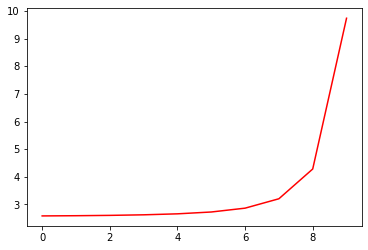

In [24]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00019411103042 [2.59185291 2.59519203 2.60594043 2.62506062 2.65959471 2.7254432
 2.86384078 3.20375815 4.28077932 9.73804437]
2 100.00019372188666 [2.60045931 2.60255005 2.6117475  2.62960815 2.66275858 2.72735743
 2.86486748 3.20424998 4.28096781 9.73804894]
3 100.00019335301948 [2.60841117 2.61084587 2.61870304 2.6353613  2.66725245 2.73040647
 2.86653547 3.20499181 4.28122939 9.73805698]
4 100.00019297303403 [2.61620822 2.61937212 2.62637678 2.64195814 2.67271244 2.73448746
 2.86901212 3.20609116 4.28158394 9.73806917]
5 100.00019258901263 [2.62418341 2.62755434 2.63454042 2.64917762 2.67889888 2.73941228
 2.87231955 3.20767123 4.28206522 9.73808619]
6 100.00019219959619 [2.63235648 2.63540572 2.64293252 2.65687789 2.68565694 2.7450204
 2.87638967 3.20982427 4.28272137 9.73810902]
7 100.00019180409895 [2.64061312 2.64333498 2.65110839 2.66494958 2.69288129 2.75119094
 2.8811287  3.2125915  4.28361106 9.73813926]
8 100.00019140424382 [2.64886652 2.65150024 2.65895307 2.6732364

62 100.01574630081628 [2.71350597 2.58806545 2.59575226 2.61030813 2.63792748 2.6958089
 2.8253384  3.15662424 4.22940079 9.75255158]
63 100.95234212103475 [2.71643257 2.58510276 2.59277116 2.60731233 2.63491897 2.6927879
 2.82230267 3.15356633 4.22629849 9.74935191]
64 100.0282835107128 [2.71872761 2.58278547 2.59043879 2.6049677  2.63256329 2.69042061
 2.81992032 3.15115911 4.22383656 9.74672942]
65 98.12169076406862 [2.71989041 2.58165892 2.58932472 2.60386397 2.63146845 2.68933412
 2.81884302 3.15009492 4.22280077 9.74582728]
66 98.02605804877439 [2.72127464 2.58029721 2.58797264 2.60251963 2.63013036 2.68800123
 2.81751482 3.1487719  4.22148774 9.7445808 ]
67 99.99667961008915 [2.72248239 2.57911147 2.58679586 2.60135001 2.62896642 2.68684187
 2.81635927 3.14761991 4.22034156 9.74347987]
68 100.59998227528646 [2.7256505  2.57586276 2.58351772 2.59805146 2.62565554 2.68352763
 2.81305512 3.14435361 4.21719759 9.74097109]
69 100.00021624859379 [2.72852374 2.57291642 2.58054467 2.595

123 100.952280926746 [2.73260235 2.57190593 2.58079293 2.59642853 2.62514719 2.68436232
 2.81586924 3.15079403 4.23237418 9.7893919 ]
124 100.17975271441193 [2.73427975 2.57023035 2.5791223  2.59475838 2.62347141 2.6826713
 2.81414512 3.14899724 4.23039221 9.78675598]
125 97.00403082837686 [2.73582943 2.5686819  2.57757827 2.59321476 2.62192267 2.68110873
 2.81255256 3.14733884 4.22856616 9.78433859]
126 96.7066909011363 [2.7352128  2.56932278 2.57822074 2.59385323 2.62254898 2.68170917
 2.81310066 3.14777404 4.22870997 9.78336945]
127 96.95377752907801 [2.73504474 2.56950693 2.57840546 2.59403338 2.62271682 2.68185156
 2.81319208 3.14775617 4.22841138 9.78201059]
128 96.99360973226513 [2.73495133 2.56961402 2.57851292 2.59413655 2.62280865 2.68192006
 2.81321391 3.14767799 4.22807659 9.78070815]
129 96.9980505203803 [2.73488663 2.56969078 2.57858997 2.59420967 2.62287145 2.68196164
 2.81321311 3.14758639 4.22775201 9.77950567]
130 96.99923779164781 [2.73483746 2.56975074 2.57865014 2.

184 100.00032858580101 [2.71440271 2.59076061 2.59982014 2.61551282 2.64413931 2.70303791
 2.83381837 3.16710059 4.24434946 9.7844678 ]
185 100.88865647650181 [2.71343453 2.59178727 2.60086897 2.6165769  2.64521236 2.70411303
 2.8348855  3.16813973 4.2453038  9.78506154]
186 101.0002267589481 [2.71256046 2.59271411 2.60181582 2.61753752 2.64618109 2.70508362
 2.83584889 3.16907784 4.24616537 9.78559757]
187 100.74003291048523 [2.7098227  2.59549769 2.60462297 2.62036202 2.64901838 2.70793033
 2.83870214 3.17193411 4.24901412 9.7883344 ]
188 101.34778778325486 [2.70975573 2.59562402 2.60477322 2.62053362 2.64921164 2.70814975
 2.83896013 3.17226236 4.24950932 9.78943703]
189 101.58811079071349 [2.71218359 2.5932671  2.60244032 2.61822532 2.64693232 2.70591058
 2.83678633 3.17021544 4.24777785 9.78894809]
190 100.02083199806266 [2.71417844 2.59133626 2.60053181 2.61633964 2.64507358 2.70408925
 2.83502602 3.16857372 4.24643079 9.78875473]
191 100.99826813764064 [2.71600174 2.58957103 2.5

244 102.99994157591146 [ 2.76209903  2.55218719  2.56612617  2.58680919  2.62137293  2.68863413
  2.83325559  3.19352356  4.3357385  10.08494469]
245 98.88760137342743 [ 2.75858089  2.55601481  2.57007326  2.59086673  2.62554806  2.69295895
  2.83781007  3.19850184  4.34167741 10.09344887]
246 102.90504491159751 [ 2.75603457  2.55882206  2.57298304  2.59387359  2.62866125  2.69621125
  2.84128018  3.20237936  4.34648898 10.10082702]
247 104.81354560609083 [ 2.75491318  2.56014812  2.57439285  2.59536697  2.63025156  2.69793488
  2.84322006  3.20473283  4.34980893 10.10692941]
248 104.29082722822363 [ 2.75188816  2.56341254  2.57775279  2.59881731  2.63380136  2.7016157
  2.8471073   3.20900761  4.35497247 10.11451437]
249 100.20234081803842 [ 2.74793346  2.56761215  2.58204938  2.60320365  2.63828416  2.70622306
  2.85190824  3.21416863  4.3609507  10.12264042]
250 101.96971413991295 [ 2.74460838  2.57115448  2.58567821  2.60691322  2.64208139  2.7101345
  2.85599832  3.21859246  4.366

301 100.00022488025044 [ 2.67503397  2.64509899  2.6617655   2.68483554  2.72177035  2.79185066
  2.94058446  3.30823628  4.46700513 10.25996481]
302 100.11874256692408 [ 2.6701542   2.64988021  2.66649714  2.68952367  2.72641586  2.79644744
  2.94511359  3.31264706  4.4711334  10.26297332]
303 100.00022037985254 [ 2.66575399  2.65419156  2.67076378  2.69375108  2.73060484  2.80059248
  2.94919763  3.31662437  4.47485596 10.26568593]
304 101.00021073185906 [ 2.66178612  2.65807929  2.6746112   2.69756312  2.73438222  2.80433023
  2.95288038  3.32021088  4.47821276 10.26813177]
305 100.00037064154124 [ 2.65821011  2.6615832   2.67807879  2.70099886  2.73778674  2.80769906
  2.95619965  3.32344344  4.48123835 10.27033627]
306 101.00007638578217 [ 2.6549877   2.66474078  2.68120368  2.70409505  2.74085483  2.81073499
  2.95919095  3.32635662  4.48396502 10.2723228 ]
307 100.01438236369755 [ 2.65190855  2.66774637  2.68417577  2.70703822  2.7437703   2.81361971
  2.9620342   3.3291289   4.

358 100.00023572947549 [ 2.62307133  2.69584368  2.71195078  2.73453562  2.77100467  2.84056565
  2.9885964   3.35504115  4.51095342 10.29239235]
359 100.00023574325314 [ 2.62305687  2.69585774  2.71196471  2.73454941  2.77101833  2.84057917
  2.98860972  3.35505415  4.51096565 10.29239864]
360 100.00023575564424 [ 2.62304383  2.69587041  2.71197727  2.73456185  2.77103065  2.84059136
  2.98862174  3.35506587  4.51097667 10.29240403]
361 100.0002357667843 [ 2.62303208  2.69588182  2.71198859  2.73457306  2.77104176  2.84060235
  2.98863257  3.35507644  4.51098661 10.2924086 ]
362 100.00023577679569 [ 2.62302148  2.6958921   2.7119988   2.73458316  2.77105177  2.84061225
  2.98864233  3.35508596  4.51099557 10.29241243]
363 100.00023578578886 [ 2.62301193  2.69590137  2.712008    2.73459227  2.77106079  2.84062118
  2.98865114  3.35509455  4.51100364 10.29241559]
364 100.00023579386351 [ 2.62300332  2.69590972  2.7120163   2.73460048  2.77106893  2.84062923
  2.98865907  3.35510229  4.5

415 100.00023585213003 [ 2.62292515  2.69598381  2.71209172  2.73467518  2.77114301  2.84070256
  2.98873135  3.35517271  4.51107695 10.29231384]
416 100.0002358517913 [ 2.62292512  2.69598381  2.71209175  2.73467522  2.77114305  2.84070259
  2.98873139  3.35517274  4.51107698 10.29231072]
417 100.00023585144825 [ 2.62292509  2.69598379  2.71209179  2.73467525  2.77114308  2.84070263
  2.98873142  3.35517277  4.511077   10.2923076 ]
418 100.00023585110127 [ 2.62292506  2.69598378  2.71209182  2.73467528  2.77114311  2.84070266
  2.98873145  3.3551728   4.51107702 10.29230447]
419 100.00023585075066 [ 2.62292503  2.69598376  2.71209184  2.7346753   2.77114314  2.84070269
  2.98873148  3.35517283  4.51107704 10.29230134]
420 100.00023585039673 [ 2.62292501  2.69598374  2.71209186  2.73467533  2.77114316  2.84070271
  2.9887315   3.35517285  4.51107706 10.29229819]
421 100.00023585003977 [ 2.622925    2.69598371  2.71209189  2.73467535  2.77114319  2.84070274
  2.98873153  3.35517287  4.5

472 100.00023583015947 [ 2.62292503  2.69598142  2.712092    2.73467549  2.77114344  2.84070301
  2.9887318   3.35517304  4.51107697 10.29212781]
473 100.00023582975165 [ 2.62292503  2.69598137  2.712092    2.73467549  2.77114344  2.84070302
  2.9887318   3.35517304  4.51107696 10.29212441]
474 100.00023582934327 [ 2.62292504  2.69598131  2.71209199  2.73467549  2.77114344  2.84070302
  2.9887318   3.35517304  4.51107696 10.29212101]
475 100.00023582893435 [ 2.62292504  2.69598126  2.71209199  2.73467549  2.77114344  2.84070302
  2.9887318   3.35517304  4.51107695 10.2921176 ]
476 100.0002358285249 [ 2.62292505  2.69598121  2.71209199  2.73467549  2.77114344  2.84070302
  2.9887318   3.35517304  4.51107695 10.29211419]
477 100.0002358281149 [ 2.62292505  2.69598116  2.71209199  2.73467549  2.77114344  2.84070302
  2.9887318   3.35517304  4.51107694 10.29211077]
478 100.00023582770434 [ 2.62292505  2.69598111  2.71209199  2.73467548  2.77114344  2.84070302
  2.98873181  3.35517304  4.51

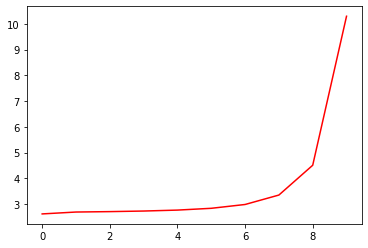

In [25]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00023581853611 [ 2.63285353  2.68606367  2.70494414  2.7298361   2.77443804  2.84380383
  2.99069933  3.35484147  4.50930762 10.28230459]
2 100.00022781862545 [ 2.64259448  2.67645144  2.69679181  2.73024657  2.76955695  2.84742316
  2.99336468  3.35501209  4.50696769 10.27250383]
3 100.0002223678222 [ 2.65187802  2.66760275  2.69127605  2.72471129  2.76772249  2.84491462
  2.99645249  3.35589818  4.50429871 10.26267792]
4 100.00030694056015 [ 2.64607007  2.67337999  2.69708553  2.73051798  2.77353167  2.85072247
  3.00226266  3.36170464  4.51009136 10.26332969]
5 100.00022045435254 [ 2.64116169  2.67825922  2.7019948   2.73542259  2.77844119  2.85562982
  3.00717214  3.36661343  4.51498534 10.26233996]
6 100.00022197056569 [ 2.63693218  2.68245775  2.70622491  2.7396465   2.78267202  2.85985779
  3.01140209  3.37084513  4.51920109 10.26012082]
7 100.0002235908529 [ 2.63323957  2.68611524  2.70991807  2.74333214  2.7863663   2.86354861
  3.01509478  3.37454162  4.52288035 10.2569

59 100.00022562327244 [2.60110231 2.70580715 2.741926   2.77508339 2.81934236 2.8961396
 3.04776621 3.40832549 4.55165459 9.91146216]
60 100.000225248134 [2.60111842 2.70543002 2.74187894 2.77506215 2.81934879 2.89614015
 3.04776844 3.40835394 4.55148313 9.90629459]
61 100.00022487988089 [2.60113677 2.7050496  2.74182761 2.77503858 2.81935291 2.89613857
 3.04776856 3.40838018 4.55130549 9.90123123]
62 100.0002245185367 [2.60115715 2.7046662  2.74177215 2.77501285 2.81935491 2.89613505
 3.04776675 3.40840436 4.55112187 9.89627221]
63 100.00022416409826 [2.6011794  2.70428013 2.74171272 2.77498511 2.81935494 2.89612975
 3.04776317 3.40842666 4.55093247 9.89141753]
64 100.0002238165386 [2.60120336 2.70389168 2.74164944 2.77495552 2.81935317 2.89612282
 3.04775799 3.40844721 4.55073748 9.88666712]
65 100.00022347580975 [2.60122887 2.7035011  2.74158242 2.7749242  2.81934971 2.89611441
 3.04775133 3.40846613 4.55053707 9.88202083]
66 100.00022314184528 [2.6012558  2.70310865 2.74151179 2.77

120 100.00021169923936 [2.60337907 2.68251832 2.73360981 2.7716679  2.81799695 2.89485257
 3.04663236 3.40822407 4.53421471 9.75793117]
121 100.0002115575871 [2.60342115 2.68217808 2.733403   2.77158196 2.81795825 2.89482339
 3.04660698 3.40820102 4.53386198 9.75732643]
122 100.00021141738564 [2.60346322 2.68183979 2.73319451 2.7714949  2.81791904 2.89479403
 3.04658148 3.40817728 4.5335084  9.75675337]
123 100.00021127860853 [2.60350528 2.68150347 2.73298438 2.77140669 2.81787931 2.89476449
 3.04655586 3.40815284 4.53315403 9.75621078]
124 100.00021114123045 [2.60354731 2.68116913 2.73277264 2.77131734 2.81783907 2.89473478
 3.04653012 3.40812771 4.5327989  9.75569747]
125 100.00021100522723 [2.60358933 2.68083676 2.73255933 2.77122682 2.8177983  2.89470488
 3.04650425 3.40810188 4.53244307 9.75521226]
126 100.0002108705757 [2.60363132 2.68050637 2.73234446 2.77113514 2.817757   2.8946748
 3.04647827 3.40807535 4.53208657 9.75475402]
127 100.00021073725364 [2.60367329 2.68017797 2.732

181 100.00020509371548 [2.605877   2.66532249 2.71901736 2.76418579 2.8144808  2.89264707
 3.04479713 3.40552417 4.51240497 9.74869024]
182 100.000205012199 [2.60591633 2.66509716 2.71876211 2.76402543 2.81439957 2.89260124
 3.0447606  3.40545851 4.51205723 9.74868926]
183 100.00020493134916 [2.60595559 2.66487346 2.71850683 2.76386395 2.81431746 2.89255499
 3.0447238  3.4053922  4.5117101  9.74868819]
184 100.0002048511585 [2.6059948  2.66465138 2.71825157 2.76370138 2.81423447 2.89250833
 3.04468673 3.40532525 4.51136359 9.74868696]
185 100.0002047716197 [2.60603394 2.66443091 2.71799632 2.76353773 2.81415059 2.89246124
 3.04464938 3.40525766 4.51101771 9.74868552]
186 100.00020469272557 [2.60607302 2.66421205 2.71774111 2.763373   2.81406581 2.89241372
 3.04461175 3.40518944 4.51067246 9.74868384]
187 100.00020461446894 [2.60611205 2.66399477 2.71748597 2.7632072  2.81398014 2.89236577
 3.04457384 3.40512058 4.51032785 9.74868188]
188 100.0002045368428 [2.60615101 2.66377907 2.71723

242 100.00020111872608 [2.60816269 2.65418364 2.70395454 2.75278587 2.80783934 2.88889686
 3.04194589 3.40045395 4.49247345 9.74805438]
243 100.00020106725574 [2.60819825 2.65403886 2.70372309 2.75257927 2.80770201 2.88881593
 3.04188623 3.4003548  4.49217001 9.74803854]
244 100.00020101614021 [2.60823375 2.65389511 2.70349229 2.75237228 2.80756381 2.88873428
 3.04182608 3.4002552  4.49186733 9.74802272]
245 100.00020096537614 [2.60826919 2.65375237 2.70326215 2.75216494 2.80742475 2.8886519
 3.04176542 3.40015514 4.49156544 9.74800692]
246 100.00020091496026 [2.60830457 2.65361064 2.70303266 2.75195723 2.80728483 2.8885688
 3.04170426 3.40005463 4.49126432 9.74799114]
247 100.00020086488928 [2.60833989 2.65346992 2.70280385 2.75174918 2.80714406 2.88848496
 3.04164259 3.39995367 4.49096398 9.7479754 ]
248 100.00020081516 [2.60837515 2.65333018 2.7025757  2.7515408  2.80700243 2.88840038
 3.04158041 3.39985227 4.49066441 9.7479597 ]
249 100.00020076576924 [2.60841035 2.65319144 2.70234

303 100.00019852621811 [2.61022622 2.64696802 2.69111775 2.73986454 2.79808003 2.88256163
 3.03727007 3.39364227 4.47536031 9.74717847]
304 100.00019849147628 [2.61025834 2.64687306 2.69092962 2.73965296 2.79790075 2.88243364
 3.03717392 3.39351854 4.47510259 9.74716564]
305 100.00019845694244 [2.61029041 2.64677875 2.6907422  2.73944156 2.79772099 2.88230489
 3.03707709 3.39339443 4.47484557 9.74715286]
306 100.00019842261493 [2.61032243 2.64668507 2.6905555  2.73923032 2.79754077 2.88217538
 3.03697957 3.39326995 4.47458925 9.74714011]
307 100.0001983884921 [2.61035439 2.64659201 2.6903695  2.73901926 2.79736009 2.88204511
 3.03688137 3.3931451  4.47433361 9.74712741]
308 100.00019835457228 [2.61038631 2.64649957 2.69018422 2.73880838 2.79717895 2.88191409
 3.03678249 3.39301988 4.47407866 9.74711474]
309 100.00019832085387 [2.61041817 2.64640775 2.68999965 2.73859768 2.79699737 2.88178231
 3.03668292 3.39289428 4.47382439 9.74710211]
310 100.00019828733524 [2.61044998 2.64631655 2.6

364 100.00019673524262 [2.61209511 2.64218797 2.68089491 2.72743176 2.78652377 2.87347145
 3.0301285  3.38540969 4.46080367 9.74646036]
365 100.000196710653 [2.6121243  2.64212442 2.68074741 2.7272383  2.78632789 2.87330317
 3.02998982 3.38526292 4.46058265 9.74644957]
366 100.00019668619474 [2.61215345 2.64206128 2.68060052 2.72704522 2.78613193 2.87313437
 3.02985047 3.38511576 4.46036211 9.74643881]
367 100.00019666186692 [2.61218255 2.64199854 2.68045423 2.72685254 2.78593589 2.87296504
 3.02971044 3.38496821 4.46014207 9.74642807]
368 100.00019663766865 [2.6122116  2.64193622 2.68030855 2.72666025 2.78573979 2.87279521
 3.02956974 3.38482027 4.45992251 9.74641736]
369 100.00019661359903 [2.61224062 2.64187429 2.68016346 2.72646836 2.78554361 2.87262486
 3.02942836 3.38467194 4.45970342 9.74640668]
370 100.00019658965718 [2.61226959 2.64181277 2.68001897 2.72627686 2.78534737 2.872454
 3.02928632 3.38452321 4.45948482 9.74639602]
371 100.00019656584222 [2.61229852 2.64175164 2.6798

425 100.00019544688872 [2.61379964 2.63897276 2.67293052 2.71639278 2.77459211 2.86242837
 3.02051868 3.37573092 4.44807707 9.74584587]
426 100.00019542891305 [2.61382637 2.63892987 2.67281615 2.71622524 2.77439937 2.86223736
 3.02034356 3.37555991 4.44787872 9.74583641]
427 100.00019541102611 [2.61385306 2.63888726 2.67270226 2.71605813 2.7742068  2.86204613
 3.02016796 3.37538851 4.44768061 9.74582696]
428 100.00019539322737 [2.61387972 2.63884491 2.67258884 2.71589147 2.7740144  2.86185468
 3.01999186 3.37521672 4.44748275 9.74581753]
429 100.00019537551633 [2.61390634 2.63880285 2.6724759  2.71572525 2.77382217 2.86166303
 3.01981528 3.37504454 4.44728513 9.74580811]
430 100.00019535789245 [2.61393292 2.63876105 2.67236344 2.71555947 2.77363011 2.86147117
 3.01963822 3.37487197 4.44708775 9.74579871]
431 100.00019534035523 [2.61395947 2.63871952 2.67225145 2.71539414 2.77343824 2.86127912
 3.01946068 3.374699   4.4468906  9.74578932]
432 100.00019532290418 [2.61398598 2.63867826 2.

486 100.00019449597623 [2.61536675 2.63680627 2.66676576 2.70697256 2.7632286  2.85053835
 3.00908068 3.36461561 4.4363027  9.74528975]
487 100.0001944825931 [2.61539143 2.63677752 2.66667736 2.70683144 2.76305029 2.850342
 3.00888298 3.36442264 4.4361131  9.74528088]
488 100.00019446927342 [2.61541608 2.63674895 2.66658933 2.70669074 2.76287227 2.85014568
 3.00868503 3.36422936 4.43592355 9.74527201]
489 100.00019445601687 [2.6154407  2.63672057 2.66650167 2.70655046 2.76269454 2.8499494
 3.00848685 3.36403577 4.43573404 9.74526315]
490 100.00019444282312 [2.61546529 2.63669239 2.66641438 2.70641059 2.76251711 2.84975316
 3.00828843 3.36384187 4.43554458 9.74525429]
491 100.00019442969185 [2.61548985 2.63666439 2.66632746 2.70627114 2.76233997 2.84955696
 3.00808979 3.36364766 4.43535516 9.74524544]
492 100.00019441662273 [2.61551437 2.63663659 2.66624091 2.70613211 2.76216313 2.8493608
 3.00789091 3.36345315 4.43516577 9.74523659]
493 100.00019440361545 [2.61553887 2.63660896 2.66615

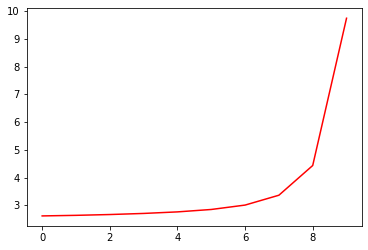

In [26]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

In [27]:
optimizer=tf.optimizers.Adam(learning_rate=0.01)
for i in range (1, 500):
    loss=run()
    print(i, loss.numpy(), h.numpy())
plt.plot(h.numpy(), 'r-')

1 100.00019431427017 [2.62543766 2.62891914 2.65715348 2.69675421 2.7529351  2.84075889
 3.0004544  3.35763742 4.4312626  9.74510018]
2 100.00019342891505 [2.63308555 2.63538284 2.6485098  2.68794819 2.74443845 2.83287197
 2.9935727  3.35224691 4.42789752 9.74497414]
3 100.00019264945965 [2.63964003 2.64239052 2.6506966  2.67898753 2.73570247 2.82465231
 2.98623119 3.34628388 4.42398828 9.74480028]
4 100.00019201534745 [2.64569673 2.64897251 2.65541921 2.67428833 2.72682077 2.816219
 2.97858119 3.33991093 4.41965126 9.74458682]
5 100.00019157417044 [2.65120926 2.65486684 2.66089276 2.67487808 2.71836707 2.80763796
 2.97070776 3.33322547 4.41496373 9.74435121]
6 100.99849011657273 [2.65643047 2.64964595 2.6556719  2.66965696 2.71314533 2.80241605
 2.96548584 3.32800363 4.40974225 9.73913329]
7 101.00010893508355 [2.66074918 2.64532987 2.65135673 2.66534287 2.70883199 2.7981044
 2.96117795 3.32370366 4.40546359 9.7349662 ]
8 100.00019236739615 [2.66455636 2.6415253  2.6475527  2.66153998

63 96.99786543903767 [2.73580263 2.57243741 2.57925387 2.5939225  2.63805647 2.728039
 2.89207109 3.25624263 4.34185797 9.68716113]
64 97.01870781063221 [2.73517499 2.57311085 2.57995065 2.59463634 2.63878214 2.72877158
 2.89280467 3.25696712 4.34254748 9.68769877]
65 99.28933313376568 [2.73663061 2.57166743 2.57851867 2.59321418 2.63736918 2.72736872
 2.89141553 3.25560189 4.34123891 9.68661393]
66 96.99845882678473 [2.7379625  2.57034651 2.5772081  2.59191249 2.63607579 2.72608443
 2.89014357 3.25435138 4.34003919 9.6856151 ]
67 97.43754206363691 [2.73783913 2.57051241 2.57739854 2.59212336 2.6363053  2.72633375
 2.89041889 3.25467044 4.34045746 9.68638378]
68 97.16137063482415 [2.73696176 2.57144609 2.57836262 2.59311263 2.63731746 2.72737016
 2.891487   3.25579162 4.34169793 9.68803458]
69 96.93828383789808 [2.7365366  2.57191869 2.57886245 2.59363477 2.63785944 2.7279325
 2.892075   3.25642139 4.34242036 9.68907697]
70 96.999936203035 [2.73615339 2.57234489 2.57931333 2.59410588 2

124 100.00026659270594 [2.72669487 2.58294131 2.59044245 2.60556287 2.64991848 2.739848
 2.90340047 3.26621522 4.34799184 9.67791478]
125 100.00028885484694 [2.72659926 2.58305411 2.59056513 2.60569273 2.65005321 2.73998543
 2.90353794 3.26634813 4.34810823 9.6779604 ]
126 100.00035385891026 [2.72651345 2.58315546 2.59067541 2.60580949 2.65017438 2.74010904
 2.9036616  3.26646769 4.34821292 9.67800139]
127 100.00052126732535 [2.72643756 2.5832454  2.59077341 2.60591336 2.65028224 2.74021912
 2.90377175 3.26657419 4.34830614 9.67803771]
128 100.00090009247616 [2.72637302 2.58332265 2.59085793 2.60600318 2.65037568 2.74031459
 2.90386736 3.26666665 4.34838698 9.67806865]
129 100.00162952260843 [2.72632336 2.58338379 2.59092562 2.60607567 2.65045147 2.74039229
 2.90394531 3.26674206 4.34845267 9.67809246]
130 100.0027267972644 [2.72629414 2.5834234  2.5909711  2.6061255  2.65050433 2.740447
 2.9040005  3.26679549 4.34849873 9.6781063 ]
131 100.00378063489377 [2.72629014 2.58343678 2.59098

185 100.00025872019357 [2.72704625 2.58277136 2.59036849 2.60556421 2.6499745  2.73994173
 2.90351592 3.26632983 4.34805648 9.67774755]
186 100.00025871552072 [2.7270467  2.58277103 2.59036809 2.60556383 2.64997412 2.73994135
 2.90351555 3.26632948 4.34805615 9.67774767]
187 100.0002587112583 [2.72704711 2.58277073 2.59036772 2.60556347 2.64997377 2.73994101
 2.90351522 3.26632915 4.34805585 9.67774781]
188 100.00025870736279 [2.7270475  2.58277045 2.59036737 2.60556315 2.64997345 2.73994068
 2.9035149  3.26632885 4.34805557 9.67774796]
189 100.00025870379558 [2.72704785 2.58277021 2.59036705 2.60556285 2.64997316 2.73994039
 2.90351461 3.26632857 4.34805531 9.67774814]
190 100.00025870052235 [2.72704817 2.58276999 2.59036676 2.60556257 2.64997288 2.73994011
 2.90351434 3.26632831 4.34805507 9.67774833]
191 100.00025869751255 [2.72704847 2.5827698  2.59036648 2.60556231 2.64997263 2.73993985
 2.90351408 3.26632806 4.34805485 9.67774853]
192 100.00025869473895 [2.72704875 2.58276962 2.5

246 100.0002586395337 [2.72705461 2.58276881 2.59036028 2.60555659 2.6499667  2.73993339
 2.9035077  3.2663219  4.34804928 9.6777661 ]
247 100.00025863884653 [2.72705469 2.58276883 2.5903602  2.60555651 2.64996662 2.7399333
 2.90350761 3.26632181 4.34804921 9.67776647]
248 100.00025863815964 [2.72705476 2.58276885 2.59036012 2.60555643 2.64996654 2.73993321
 2.90350751 3.26632172 4.34804913 9.67776683]
249 100.00025863747297 [2.72705484 2.58276887 2.59036003 2.60555636 2.64996645 2.73993311
 2.90350742 3.26632163 4.34804905 9.67776719]
250 100.00025863678643 [2.72705492 2.58276889 2.59035995 2.60555628 2.64996637 2.73993302
 2.90350733 3.26632154 4.34804897 9.67776756]
251 100.00025863610001 [2.727055   2.58276891 2.59035986 2.60555621 2.64996629 2.73993293
 2.90350724 3.26632145 4.34804889 9.67776792]
252 100.00025863541367 [2.72705507 2.58276893 2.59035978 2.60555613 2.64996621 2.73993284
 2.90350714 3.26632136 4.34804881 9.67776829]
253 100.00025863472734 [2.72705515 2.58276895 2.59

KeyboardInterrupt: 